In [20]:
#import all the libraries
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_function import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [21]:
#load training cars and nocars images
cars = glob.glob('./dataset/vehicles/*/*.png')
nocars = glob.glob('./dataset/non-vehicles/*/*.png')
print('The number of cars images: ',len(cars))
print('The number of no-cars images',len(nocars))

The number of cars images:  8792
The number of no-cars images 8968


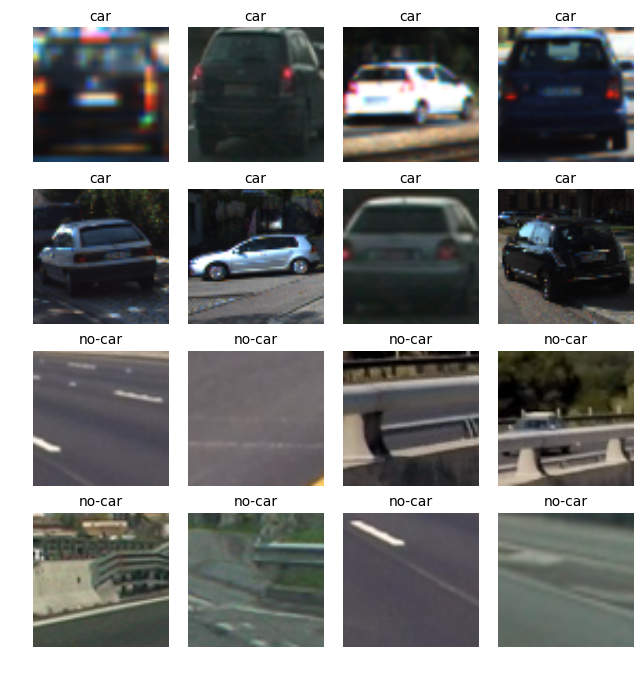

In [22]:
#visualize some data
fig,axs = plt.subplots(4,4,figsize=(8,8))
fig.subplots_adjust(hspace=0.2,wspace=0.001)
axs = axs.ravel()

for i in np.arange(8):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     print(img.shape)
    axs[i].axis('off')
    axs[i].set_title('car',fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(nocars[np.random.randint(0,len(nocars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('no-car',fontsize=10)
    axs[i].imshow(img)

In [23]:
##HOG function
#Define a function to extract hog feature of an image
def get_hog_feature(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    if vis == True:
        features,hog_image = hog(img,orientations=orient,
                                                    pixels_per_cell=(pix_per_cell,pix_per_cell),
                                                    cells_per_block=(cell_per_block,cell_per_block),
                                                    transform_sqrt=True,
                                                    visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    else:
            features = hog(img,orientations=orient,
                                      pixels_per_cell=(pix_per_cell,pix_per_cell),
                                      cells_per_block=(cell_per_block,cell_per_block),
                                      transform_sqrt=True,visualise=vis,feature_vector=feature_vec)
#             print('in get_hog_feature,Image Shape is: ',img.shape,' Feature size is : ',features.shape,' orient is: ',orient)
            return features

In [19]:
# skimage hog test
hog_feat = True
color_space = 'HLS'
orient = 11
pix_per_cell = 9
cell_per_block = 2
hog_channel = 'ALL'

myimg = mpimage.imread(test_imgs[0])
myimg = myimg[1:65,1:65,0]

hog_feature = hog(myimg,orientations=11,pixels_per_cell=(9,9),cells_per_block=(2,2),
                                 transform_sqrt=True,visualise=False,feature_vector=True)
print(myimg.shape)
print(hog_feature.shape)
    

NameError: name 'test_imgs' is not defined

In [24]:
#Define a function to extract binned color features 
def bin_spatial(img,size=(32,32)):
    #Use cv2.resize().ravel() to create the feature vector 
    features = cv2.resize(img,size).ravel()
    return features


In [25]:
#Define a function to compute color histogram features
def color_hist(img,nbins=32,bins_range=(0,256)):
    #Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    
    #Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    return hist_features
    

In [35]:
#Define a funcion to extract features from an image,include binned color feature,color histogram feature and hog feature
def extract_features(img,color_space='RGB',spatial_size=(32,32),
                                    hist_bins=32,orient=11,
                                    pix_per_cell=8,cell_per_block=2,hog_channel=0,
                                    spatial_feat=True,hist_feat=True,hog_feat=True):
    #Create a list to append feature vectors to
    features = []
    # Apply color conversion if other color space than 'RGB
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    else:
        feature_img = np.copy(img)
    
    #For debug
#     flag = True
      
    
    # Add spatial feature or not
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_img,size=spatial_size)
        features.append(spatial_features)
   
    #Add color hist feature or not
    if hist_feat == True:
        hist_features = color_hist(feature_img,nbins=hist_bins)
        features.append(hist_features)
        
#         if flag == True:
#             print('Debug: Shape of hist feature: ',hist_features.shape)
            
    # Add hog feature or not
    if hog_feat == True:
        # Add all channels features or only one
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_img.shape[2]):
                hog_feature = get_hog_feature(feature_img[:,:,channel],
                                                                                orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True)
#                 print('channel: %d, shape of feature: ',channel,hog_feature.shape)
                hog_features.append(hog_feature)
                
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_feature(feature_img[:,:,hog_channel],
                                                                   orient,pix_per_cell,cell_per_block,
                                                                    vis=False,feature_vec=True)
        features.append(hog_features)
        
#         return features   
        return np.concatenate(features)
    

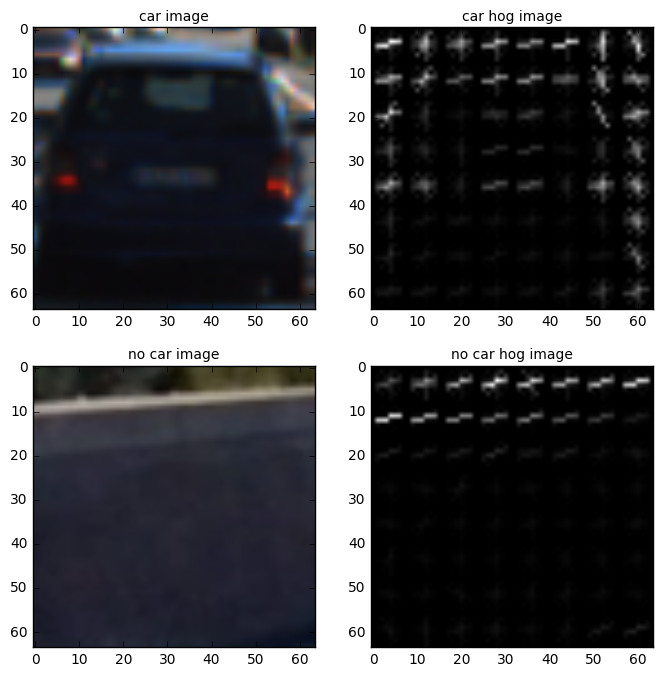

In [36]:
#Visualize HOG feature of car image and non-car image
car_img = cv2.imread(cars[np.random.randint(0,len(cars))])
car_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB)
# car_img = mpimage.imread(cars[np.random.randint(0,len(cars))])
_,car_hog_img = get_hog_feature(car_img[:,:,0],9,8,2,vis=True,feature_vec=True)

no_car_img = cv2.imread(nocars[np.random.randint(0,len(nocars))])
no_car_img = cv2.cvtColor(no_car_img,cv2.COLOR_BGR2RGB)
# no_car_img = mpimage.imread(cars[np.random.randint(0,len(nocars))])
_,no_car_hog_img = get_hog_feature(no_car_img[:,:,2],9,8,8,vis=True,feature_vec=True)


fig,axs = plt.subplots(2,2,figsize=(8,8))
fig.subplots_adjust(hspace=0.2,wspace=0.2)
axs = axs.ravel()
axs[0].imshow(car_img)
axs[0].set_title('car image',fontsize=10)
axs[1].imshow(car_hog_img,cmap='gray')
axs[1].set_title('car hog image',fontsize=10)

axs[2].imshow(no_car_img)
axs[2].set_title('no car image',fontsize=10)
axs[3].imshow(no_car_hog_img,cmap='gray')
axs[3].set_title('no car hog image',fontsize=10)


In [37]:
#Extract all the images features.Shuffle and split
#HOG parameters setting
hog_feat = True
color_space = 'HLS'
orient = 11
pix_per_cell = 9
cell_per_block = 2
hog_channel = 'ALL'

#binned spatial feature parameter
spatial_feat = True
spatial_size = (16,16)

#Color histogram feature parameter
hist_feat = True
hist_bins = 32

#Measure time for extracting all the features
t1 = time.time()

#Car feature list and non-car feature list
all_car_features = []
all_non_car_features = []

for imgpath in cars:
    car_img = mpimage.imread(imgpath)
    car_feature = extract_features(car_img,color_space=color_space,
                                                   spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                                    pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                     spatial_feat=True,hist_feat=True,hog_feat=True )
    all_car_features.append(car_feature)

print(len(all_car_features))
    
for imgpath in nocars:
    no_car_img = mpimage.imread(imgpath)
    no_car_feature = extract_features(no_car_img,color_space=color_space,
                                                   spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                                    pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                     spatial_feat=True,hist_feat=True,hog_feat=True )
    all_non_car_features.append(no_car_feature)

t2 = time.time()
print('Extracting features consumes ',round(t2-t1,2),' seconds')

print('The length of car features: ',len(all_car_features))
print('The lengthe of not-car features: ',len(all_non_car_features))

#Stack car features and not-car features together
all_features = np.vstack((all_car_features,all_non_car_features)).astype(np.float64)
print('The lengthe of all features: ',len(all_features))

#Fit a per-column scaler
scaler = StandardScaler().fit(all_features)
all_features_scaled = scaler.transform(all_features)

#Define labels vector
labels = np.hstack((np.ones(len(all_car_features)),np.zeros(len(all_non_car_features)))).astype(np.float64)
print('The length of all lables',len(labels))

#Split data into randomized training and test sets
rand_state = np.random.randint(0,100)
x_train,x_test,y_train,y_test = train_test_split(all_features_scaled,labels,test_size=0.2,random_state=rand_state)

print('The length of training dataset: ',len(x_train))
print('The length of test datast',len(y_train))

8792
Extracting features consumes  63.91  seconds
The length of car features:  8792
The lengthe of not-car features:  8968
The lengthe of all features:  17760
The length of all lables 17760
The length of training dataset:  14208
The length of test datast 14208


In [38]:
#Create a linear classifier
svc = LinearSVC()

#Measure training time
t1 = time.time()
svc.fit(x_train,y_train)
t2 = time.time()

print('Training time : ',round(t2-t1,2),'seconds')

#Check the score of SVC classifier
print('Training Accuracy of SVC ',svc.score(x_train,y_train))
print('Test Accuracy of SVC: ',svc.score(x_test,y_test))

#Check the prediction time
t1 = time.time()
num_predict = 10
print('SVC Predict: ',svc.predict(x_train[0:num_predict]))
print('Real label: ',y_train[0:num_predict])
t2 = time.time()
print(round(t2-t1,2),' seconds used to pridicet ',num_predict,' samples')

Training time :  6.41 seconds
Training Accuracy of SVC  1.0
Test Accuracy of SVC:  0.984515765766
SVC Predict:  [ 1.  1.  0.  0.  0.  1.  0.  0.  1.  1.]
Real label:  [ 1.  1.  0.  0.  0.  1.  0.  0.  1.  1.]
0.01  seconds used to pridicet  10  samples


In [42]:
#Random Test SVC Acuracy
idx = np.random.randint(len(x_train),size=40)
print(idx)
print('SVC Predict: ',svc.predict(x_train[idx]))
print('Real label: ',y_train[idx])

print(np.equal(svc.predict(x_train[idx]),y_train[idx]))  
# print('Accuracy is: ',np.mean(np.sum(np.equal(svc.predict(idx),y_train[idx]))))


[ 2365  6249 12155  1558  3211  9782  4376  9841  6270  8342  7641  4718
  3904  8377  9427  3275 11354 10026 10839  6953  1199  6432    70  1894
  6070  6920   582 10172  3040  7196 12241  9619 12364 11831 11038  5803
  8204 12406  6419  7310]
SVC Predict:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.
  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  0.  0.]
Real label:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.
  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  0.  0.]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [43]:
#Save data and trained SVC model
pickle_file = 'train_test_data.p'
try:
    with open(pickle_file,'wb') as pfile:
        pickle.dump(
                            {
                                'x_train':x_train,
                                'y_train':y_train,
                                'x_test':x_test,
                                'y_test':y_test
                            } ,
                            pfile,pickle.HIGHEST_PROTOCOL
                            )
except Exception as e:
    print('Unable to save data,error happens: ',e)
    raise
print('Training and test data saved')

pickle_file = 'svc_classifier.p'
try:
    with open(pickle_file,'wb') as pfile:
        pickle.dump(
                            {'svc':svc},pfile,pickle.HIGHEST_PROTOCOL
                            )
except Exception as e:
    print('Error happens:',e)
    raise
print('SVC saved')

Training and test data saved
SVC saved


Size of test_image :  (720, 1280, 3)


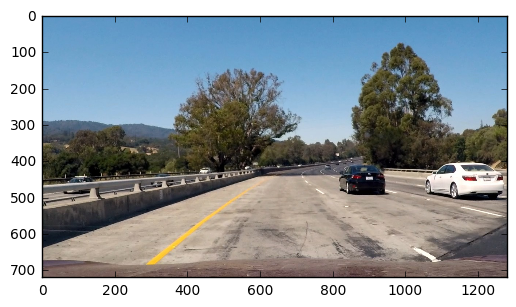

In [44]:
#Explore the test image
test_imgs = glob.glob('./test_images/*.jpg')
# print(test_imgs)
test_img = mpimage.imread(test_imgs[0])
print('Size of test_image : ',test_img.shape)
plt.imshow(test_img)

In [45]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img,x_start_stop=[None,None],y_start_stop=[None,None],
                            window_size=(64,54),overlap_size=(0.5,0.5)):
    # If x or y start and stop positions not defined,set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    #Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    #Compute the number of pixels per step in x and y direciton
    nx_pix_per_step = np.int(window_size[0] * (1 - overlap_size[0]))
    ny_pix_per_step = np.int(window_size[1] * (1 - overlap_size[1]))
    
    #Computer the number of window in x and y direction
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    #Create a list to put all windows into
    window_list = []
    #Loop through finding x and y window positions
    #Note: you can vectorize this step, but in practice,you'll be considering windows one by one with
    # classifier,so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            #Calculate window positon
            startx = int(xs*nx_pix_per_step + x_start_stop[0])
            endx = int(startx + window_size[0])
            starty = int(ys*ny_pix_per_step + y_start_stop[0])
            endy = int(starty + window_size[1])
            
            window_list.append(((startx,starty),(endx,endy)))
    
    return window_list
      
       

In [69]:
#For debug 
pre_true = 0

In [76]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img,windows,clf,scaler,color_space='RGB',
                                  spatial_size=(16,16),hist_bins=32,
                                  hist_range=(0,256),orient=11,pix_per_cell=9,cell_per_block=2,
                                  hog_channel=0,spatial_feat=True,
                                  hist_feat=True,hog_feat=True):
    #Create an empty list to receive positive detection windows
    on_windows = []
    
    #For debug 
    flag = True
        
    #Iterate over all windows in the list
    for window in windows:
        # Resize the ROI image 
        roi_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
        #         if flag == True:
        #             print('Number of windows: ',len(windows))
        #             print('Shape of image : ',roi_img.shape)
        #             print('Debug: Some parameters: hog_channel: ',hog_channel,
        #                         'color_space: ',color_space,' orient; ',orient,
        #                      'pix_per_cell: ',pix_per_cell,' cell_per_block: ',cell_per_block,
        #                       'hog_feat: ',hog_feat)
        #             flag = False
        
        # Extract features for the resized ROI window
        roi_features = extract_features(roi_img,color_space=color_space,
                                                   spatial_size=spatial_size,hist_bins=hist_bins,
                                                   pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                                   hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                   hist_feat=hist_feat,hog_feat=hog_feat)
        # Use sklearn.StandardScaler to transform the features
        roi_features = scaler.transform(np.array(roi_features).reshape(1,-1))
        
#         print('Shape of roi_features : ',roi_features.shape)
#         roi_features = scaler.transform(roi_features)
        #Predict using svc classifier
        
        prediction = clf.predict(roi_features)
        
        if prediction == 1:
            on_windows.append(window)
            global pre_true
            pre_true += 1
#             plt.figure()
#             plt.imshow(roi_img)
        
        #Return windows for positive detections
    return on_windows
        


In [77]:
#Define a function to search windows in a full image,get all the windows that may have a car
def search_all_scales(img,classifier=None):
    hot_windows = []
    all_windows = []
    
    x_start_stop = [[None,None],[None,None],[None,None],[None,None]]
    #window size
    w0,w1,w2,w3 = 240,180,120,70
    # overlap percentage
    o0,o1,o2,o3 = 0.75,0.75,0.75,0.75
    window_size = [(w0,w0),(w1,w1),(w2,w2),(w3,w3)]
    overlap_size = [(o0,o0),(o1,o1),(o2,o2),(o3,o3)]
    yi0,yi1,yi2,yi3 = 380,380,395,405
#     yi0,yi1,yi2,yi3 = 350,350,380,380
    y_start_stop = [[yi0,yi0+w0/2],[yi1,yi1+w1/2],[yi2,yi2+w2/2],[yi3,yi3+w3/2]]
#     y_start_stop = [[yi0,yi0+w0],[yi1,yi1+w1],[yi2,yi2+w2],[yi3,yi3+w3]]
    
    for i in range(len(y_start_stop)):
        windows = slide_window(img,x_start_stop=x_start_stop[i],y_start_stop=y_start_stop[i],
                                              window_size=window_size[i],overlap_size=overlap_size[i])
        all_windows += [windows]
        print('in search all scale:',type(classifier))
        hot_windows += search_windows(img,windows,classifier,scaler,color_space=color_space,
                                                         spatial_size=spatial_size,hist_bins=hist_bins,
                                                         orient=orient,pix_per_cell=pix_per_cell,
                                                         cell_per_block=cell_per_block,
                                                         hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                         hist_feat=hist_feat,hog_feat=hog_feat)
        
    return hot_windows,all_windows      
    
        

In [78]:
# Draw bounding boxes function
def draw_boxes(img,bboxes,color=(0,0,255),thick=6):
    #make a copy of the image
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy

<class 'sklearn.svm.classes.LinearSVC'>
in search all scale: <class 'sklearn.svm.classes.LinearSVC'>
in search all scale: <class 'sklearn.svm.classes.LinearSVC'>
in search all scale: <class 'sklearn.svm.classes.LinearSVC'>
in search all scale: <class 'sklearn.svm.classes.LinearSVC'>
4
len of hot windows:  162
pre_true:  324


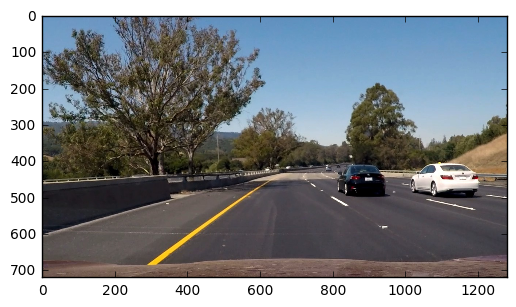

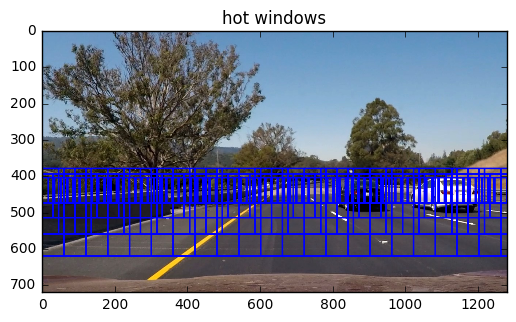

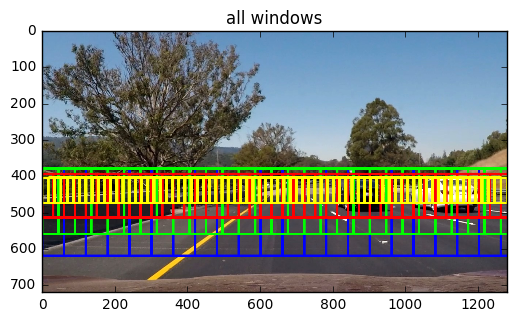

In [80]:
#HOG parameters setting
hog_feat = True
color_space = 'HLS'
orient = 11
pix_per_cell = 9
cell_per_block = 2
hog_channel = 'ALL'

#binned spatial feature parameter
spatial_feat = True
spatial_size = (16,16)

#Color histogram feature parameter
hist_feat = True
hist_bins = 32

with open('svc_classifier.p',mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc']

test_imgs = glob.glob('./test_images/*.jpg')

test_img1 = mpimage.imread(test_imgs[4])
# plt.imshow(mpimage.imread(test_imgs[0]))

print(type(svc))
hot_windows,all_windows = search_all_scales(test_img1,classifier=svc)
print(len(all_windows))
# print(all_windows[0])
# allwindows_img =np.int32(np.copy(test_img1)) 
# print(allwindows_img[:1,:1,:])
print('len of hot windows: ',len(hot_windows))
print('pre_true: ',pre_true)

plt.imshow(test_img1)

window_img = np.copy(test_img1)
window_img = draw_boxes(window_img, hot_windows, color=(0, 0, 255), thick=4)          
plt.figure()
plt.imshow(window_img)
plt.title('hot windows')

allwindows_img = np.copy(test_img1)
for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,255)
        if ind==1: color= (0,255,0)
        if ind==2: color= (255,0,0)
        if ind==3: color= (255,255,0)
        
        #allwindows_img is wrong,why?
        #         allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)   
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)         
plt.figure()
plt.imshow(allwindows_img)
plt.title('all windows')
